# Determining constants for the Leishman--Beddoes dynamic stall model

In [255]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin, cos, exp, pi, log, sqrt
import pandas as pd
from scipy.optimize import curve_fit
plt.style.use("ggplot")

In [256]:
# Function for loading data
def load(foil="NACA0021", xfoil=False, csv=False):
    if csv:
        fpath = "data/{}_3.6e5_Sheldahl.csv".format(foil)
        df = pd.read_csv(fpath)
    else:
        if xfoil:
            fpath = "data/{}_XFOIL.txt".format(foil)
        else:
            fpath = "data/{}.dat".format(foil)
        alpha = []
        cl = []
        cd = []
        cm = []
        with open(fpath) as f:
            for line in f.readlines():
                if line.strip()[:2] == "//":
                    pass
                else:
                    line = line.replace("(", "")
                    line = line.replace(")", "")
                    line = line.split()
                    alpha.append(float(line[0]))
                    cl.append(float(line[1]))
                    cd.append(float(line[2]))
                    try:
                        cm.append(float(line[4]))
                    except IndexError:
                        cm.append(np.nan)
        df = pd.DataFrame()
        df["alpha_deg"] = np.asarray(alpha)
        df["cl"] = np.asarray(cl)
        df["cd"] = np.asarray(cd)
        df["cm"] = np.asarray(cm)
    df["alpha_rad"] = df.alpha_deg/180.0*np.pi
    df["cn"] = df.cl*np.cos(df.alpha_rad) - df.cd*np.sin(df.alpha_rad)
    df["ct"] = df.cl*np.sin(df.alpha_rad) - df.cd*np.cos(df.alpha_rad)
    return df

We want to find the constants $S_1$ and $S_2$ that relate the Kirchhoff separation point $f$ to the normal force coefficient.

$$
C_N = C_{N_\alpha} \left( \frac{1 + \sqrt{f}}{2} \right)^2 \alpha
$$

Rearranging we have

$$
f = \left(2\sqrt{\frac{C_N}{\alpha C_{N_\alpha}}} - 1\right)^2
$$

The separation point is then

$$
f = 1 - 0.3 \exp \left[ (\alpha - \alpha_1)/S_1 \right]
$$

for $\alpha \leq \alpha_1$, and for $\alpha > \alpha_1$

$$
f = 0.04 + 0.66 \exp \left[ (\alpha_1 - \alpha)/S_2 \right].
$$

We will use formulas for an exponential curve fit of the form

$$
y = A \mathrm{e}^{Bx}.
$$

$$
y \equiv \frac{1-f}{0.3},
$$

$$
B \equiv 1/S_1,
$$

$$
x \equiv \alpha - \alpha_1.
$$

From [Wolfram MathWorld](http://mathworld.wolfram.com/LeastSquaresFittingExponential.html):
$$
a = \frac{\sum x^2 y \sum y \ln y - \sum xy \sum xy \ln y}
{\sum y \sum x^2 y - \left( \sum xy \right)^2}
$$

$$
b = \frac{\sum y \sum xy \ln y - \sum xy \sum y \ln y}
{\sum y \sum x^2 y - \left( \sum xy \right)^2}
$$


Where $B \equiv b$ and $A \equiv \exp (a)$. However, we are already specifying $A=1$, so this is not quite right.

In [257]:
"""
Least squares fitting for finding s1 and s2
Kept as close to the C++ code as possible to return back

Constants from f equation
    f = A - B*exp ...
    f = C + D exp ...
"""

def calc_s1_s2(df, alpha1, cn_alpha, A=1, B=0.3, C=0.04, D=0.66):
    sumY = 0.0
    sumXYLnY = 0.0
    sumXY = 0.0
    sumYLnY = 0.0
    sumX2Y = 0.0
    sumLnY = 0.0
    sumX2 = 0.0
    sumX = 0.0
    sumXLnY = 0.0
    alphaLowerLimit = 0.0
    alphaUpperLimit = alpha1

    #Translational stuff
    alphaDegList = df.alpha_deg.values
    clList = df.cl.values
    cdList = df.cd.values
    CNAlpha = cn_alpha
    mag = abs
    
    # Calculate S1
    for i in range(len(alphaDegList)):
        alphaRad = alphaDegList[i]/180.0*pi
        cn = clList[i]*cos(alphaRad) - cdList[i]*sin(alphaRad)
        if (alphaRad >= alphaLowerLimit and alphaRad <= alphaUpperLimit):
            if alphaRad == 0.0: # Have not done this in turbinesFoam yet
                f = 0.0
            else:
                f = pow((sqrt(abs(cn)/CNAlpha/abs(alphaRad))*2.0 - 1.0), 2)
            x = abs(alphaRad) - alpha1
            y = (f - A)/(-B)
            if (f > 0 and f < 1 and y > 0):
                sumY += y
                sumXYLnY += x*y*log(y)
                sumXY += x*y
                sumYLnY += y*log(y)
                sumX2Y += x*x*y
                sumLnY += log(y)
                sumX2 += x**2
                sumX += x
                sumXLnY += x*log(y)

    a = (sumLnY*sumX2 - sumX*sumXLnY)/(sumX2 - sumX**2)
    b = (sumY*sumXYLnY - sumXY*sumYLnY)/(sumY*sumX2Y - sumXY*sumXY)
    S1 = 1.0/b

    # Calculate S2
    sumY = 0.0
    sumXYLnY = 0.0
    sumXY = 0.0
    sumYLnY = 0.0
    sumX2Y = 0.0
    sumLnY = 0.0
    sumX2 = 0.0
    sumX = 0.0
    sumXLnY = 0.0
    alphaLowerLimit = alpha1
    alphaUpperLimit = 25/180*pi
    for i in range(len(alphaDegList)):
        alphaRad = alphaDegList[i]/180.0*pi
        cn = clList[i]*cos(alphaRad) - cdList[i]*sin(alphaRad)
        if (alphaRad > alphaLowerLimit and alphaRad <= alphaUpperLimit):
            f = pow((sqrt(mag(cn)/CNAlpha/mag(alphaRad))*2.0 - 1.0), 2)
            x = alpha1 - abs(alphaRad);
            y = (f - C)/(D);
            if (f > 0 and f < 1 and y > 0):
                sumY += y
                sumXYLnY += x*y*log(y)
                sumXY += x*y
                sumYLnY += y*log(y)
                sumX2Y += x*x*y
                sumLnY += log(y)
                sumX2 += x**2
                sumX += x
                sumXLnY += x*log(y)

    a = (sumLnY*sumX2 - sumX*sumXLnY)/(sumX2 - sumX**2)
    b = (sumY*sumXYLnY - sumXY*sumYLnY)/(sumY*sumX2Y - sumXY*sumXY)
    S2 = 1.0/b
    
    return S1, S2

In [258]:
def calc_s1_s2_alt(df, alpha1, cn_alpha, A=1, B=0.3, C=0.04, D=0.66):
    """
    Using scipy.optimize.curve_fit
    
    import numpy as np
    from scipy.optimize import curve_fit
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c
        
    >>> xdata = np.linspace(0, 4, 50)
    >>> y = func(xdata, 2.5, 1.3, 0.5)
    >>> ydata = y + 0.2 * np.random.normal(size=len(xdata))
    
    >>> popt, pcov = curve_fit(func, xdata, ydata)
    """
    # Slicing
    ind = np.logical_and(df.alpha_deg >=0, df.alpha_deg <= 25)
    alpha = df.alpha_rad[ind].values
    alpha_low = alpha[alpha <= alpha1]
    alpha_high = alpha[alpha > alpha1]
    cn_low = df.cn[ind][alpha <= alpha1].values
    cn_high = df.cn[ind][alpha > alpha1].values
    
    def func_lower(alpha, s1):
        return A - B*np.exp((alpha - alpha1)/s1)
    
    f = (2*np.sqrt(cn_low/cn_alpha/alpha_low) - 1)**2
    f[0] = 0.0
    popt, pcov = curve_fit(func_lower, alpha_low, f)
    s1 = popt[0]

    def func_upper(alpha, s2):
        return C + D*np.exp((alpha1 - alpha)/s2)
    
    f = (2*np.sqrt(cn_high/cn_alpha/alpha_high) - 1)**2
    popt, pcov = curve_fit(func_upper, alpha_high, f)
    s2 = popt[0]
    
    return s1, s2

alpha_ss = 14.0
cn_alpha = 4.357
alpha1 = 0.232
S1 = 0.019
S2 = 0.052
S1_alt = 0.012
S2_alt = 0.063
24
24


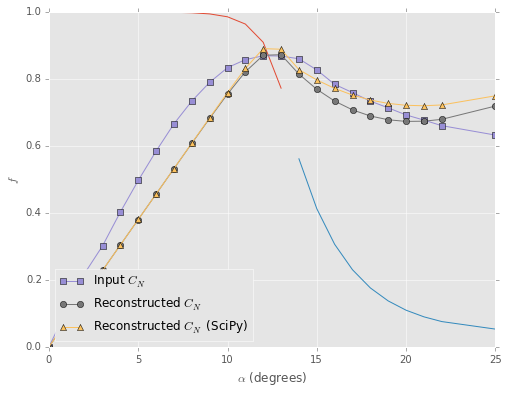

In [259]:
df = load("NACA0021", xfoil=False, csv=True)
frac_cn_alpha = 0.75 # Fraction of static stall angle to look for cn slope
frac_alpha1 = 0.95 # Fraction of static stall angle to define alpha1

# Find static stall angle
d_cd_d_alpha = np.diff(df.cd)/np.diff(df.alpha_deg)
n = np.where(d_cd_d_alpha > 0.04)[0]
alpha_ss = df.alpha_deg[n]
alpha_ss = alpha_ss[alpha_ss > 0].iloc[0]
print("alpha_ss = {:.1f}".format(alpha_ss))

# Calculate normal force slope
alpha1 = alpha_ss*frac_cn_alpha
alpha0 = alpha_ss*0.1
dalpha = alpha1 - alpha0
cn1 = np.interp(alpha1, df.alpha_deg, df.cn)
cn0 = np.interp(alpha0, df.alpha_deg, df.cn)
cn_alpha = (cn1 - cn0)/(dalpha/180.0*np.pi)
print("cn_alpha = {:.3f}".format(cn_alpha))

# Find critical normal force coefficient
A, B, C, D = 1.0, 0.3, 0.04, 0.66 # Original model
# A, B, C, D = 1.0, 0.4, 0.02, 0.58 # 3G model
fcrit = A - B
alpha1 = (alpha_ss*frac_alpha1)/180.0*np.pi
print("alpha1 = {:.3f}".format(alpha1))
cn1 = cn_alpha*alpha1*((1 + np.sqrt(fcrit))/2.0)**2

# Put in some values for s1 and s2 (from turbinesFoam)
s1 = 0.109504058813
s2 = 0.0355536753234
s1_alt, s2_alt = calc_s1_s2_alt(df, alpha1, cn_alpha, A, B, C, D)
s1, s2 = calc_s1_s2(df, alpha1, cn_alpha, A, B, C, D)
print("S1 = {:.3f}".format(s1))
print("S2 = {:.3f}".format(s2))
print("S1_alt = {:.3f}".format(s1_alt))
print("S2_alt = {:.3f}".format(s2_alt))

ind = np.logical_and(df.alpha_deg >=0, df.alpha_deg <= 28)
alpha = df.alpha_rad[ind]
alpha_low = alpha[alpha <= alpha1]
alpha_high = alpha[alpha >= alpha1]
f_low = 1.0 - 0.3*np.exp((alpha_low - alpha1)/s1)
f_high = 0.04 + 0.66*np.exp((alpha1 - alpha_high)/s2)
f_low_alt = 1.0 - 0.3*np.exp((alpha_low - alpha1)/s1_alt)
f_high_alt = 0.04 + 0.66*np.exp((alpha1 - alpha_high)/s2_alt)

# Reconstruct normal force from f
cn_low = cn_alpha*alpha_low*((1 + np.sqrt(f_low))/2)**2
cn_high = cn_alpha*alpha_high*((1 + np.sqrt(f_high))/2)**2
cn = np.hstack((cn_low, cn_high))
cn_alt = np.hstack((cn_alpha*alpha_low*((1 + np.sqrt(f_low_alt))/2)**2,
                   (cn_alpha*alpha_high*((1 + np.sqrt(f_high_alt))/2)**2)))

print(len(cn))
print(len(alpha))

plt.figure(figsize=(8, 6))
plt.plot(alpha_low*180/pi, f_low)
plt.plot(alpha_high*180/pi, f_high)
plt.plot(alpha*180/pi, df.cn[ind], "-s", label=r"Input $C_N$")
plt.plot(alpha*180/pi, cn, "-o", label=r"Reconstructed $C_N$")
plt.plot(alpha*180/pi, cn_alt, "-^", label=r"Reconstructed $C_N$ (SciPy)")
plt.xlabel(r"$\alpha$ (degrees)")
plt.ylabel("$f$")
plt.legend(loc="lower left")
plt.savefig("figures/f.pdf")
plt.show()

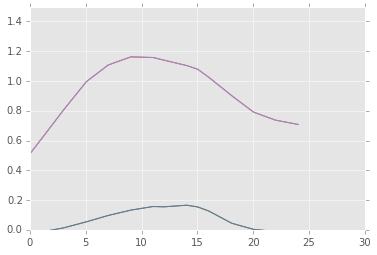

In [260]:
df = load("S826_Ostavan")
plt.plot(df.alpha_deg, df.cn)
plt.plot(df.alpha_deg, df.ct)
df = load("S826_Ostavan")
plt.plot(df.alpha_deg, df.cn)
plt.plot(df.alpha_deg, df.ct)
plt.xlim((0, 30))
plt.ylim((0, 1.5))
plt.show()

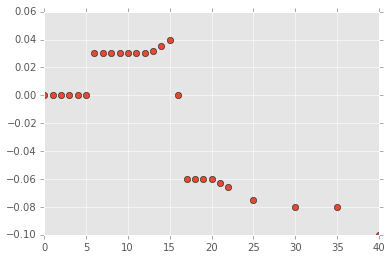

In [261]:
df = load("NACA0021", xfoil=False, csv=True)
df = df[df.alpha_deg <= 40]
plt.plot(df.alpha_deg, df.cm, "o")
plt.show()

## Relating $f$ to $C_m$

From Leishman and Beddoes (1989):

$$
\frac{C_m}{C_n} = K_0 + K_1(1-f) + K_2 \sin (\pi f^m),
$$

Where $K_0 = (0.25 - x_{ac})$, $m$ can be 1/2, 1, or 2 depending on which fits the curve best. Note that $m$ is just a coefficient, and is not related to the moment.


### Least squares fitting

$$
S = \sum_{f_i} \left( y(f) - C_m/C_n \right)^2
$$

$$
S = \sum_{f_i} \left( K_0 + K_1(1-f) + K_2 \sin (\pi f^m) - C_m/C_n \right)^2
$$

$$
\frac{\partial S}{\partial K_1} 
= 2 \sum_{f_i} \left[ \left( K_0 + K_1(1-f) + K_2 \sin (\pi f^m) - C_m/C_n \right) (1-f) \right]
$$

$$
\frac{\partial S}{\partial K_2} 
= 2 \sum_{f_i} \left[ \left( K_0 + K_1(1-f) + K_2 \sin (\pi f^m) - C_m/C_n \right) (\sin (\pi f^m)) \right]
$$

Rearrange into the form:

$$
Ax = b
$$

$$
\begin{bmatrix}
    A_{11} & A_{12} \\
    A_{21} & A_{22}
\end{bmatrix}
\begin{bmatrix}
    K_1 \\
    K_2
\end{bmatrix}
= \begin{bmatrix}
    F_{11} (C_m/C_n) \\
    F_{21} (C_m/C_n)
\end{bmatrix}
$$

$$
\begin{bmatrix}
    \sum (1-f)^2 & \sum \sin(\pi f^m)(1-f) \\
    \sum \sin(\pi f^m)(1-f) & \sum \sin^2 (\pi f^m)
\end{bmatrix}
\begin{bmatrix}
    K_1 \\
    K_2
\end{bmatrix}
= \begin{bmatrix}
    \sum C_m/C_n (1-f) - K_0 \sum (1-f) \\
    \sum C_m/C_n \sin(\pi f^m) - K_0 \sum \sin (\pi f^m)
\end{bmatrix}
$$


### Useful example on least squares fitting in OpenFOAM

https://openfoamwiki.net/index.php/Howto_simpleMatrixLeastSquareFit

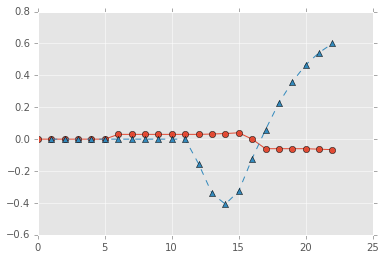

In [262]:
k0 = 0.0
m = 1
df = load("NACA0021", xfoil=False, csv=True)
df = df[df.alpha_deg <= 24]
f = pow((sqrt(abs(df.cn)/cn_alpha/abs(df.alpha_rad))*2.0 - 1.0), 2)
f[f > 1] = 1
cm, cn = df.cm, df.cn
from numpy import sin, sum, pi

A = np.array([[sum((1 - f)**2), sum(sin(pi*f**m))],
              [sum(sin(pi*f**m)*(1 - f)), sum((sin(pi*f**m))**2)]])

b = np.array([sum(cm/cn*(1 - f)) - k0*sum(1 - f),
              sum(cm/cn*sin(pi*f**m)) - k0*sum(sin(pi*f**m))])

k1, k2 = np.linalg.solve(A, b)

cm_fit = (k0 + k1*(1 - f) + k2*sin(pi*f**m))*cn

plt.plot(df.alpha_deg, df.cm, "-o")
plt.plot(df.alpha_deg, cm_fit, "--^")

0.0189344580562 0.019694260315372053


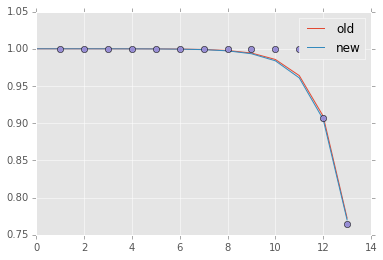

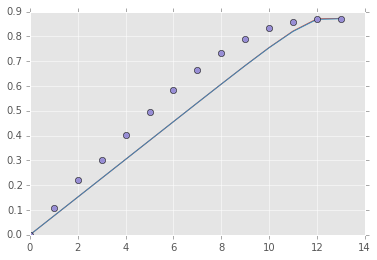

In [263]:
# Redo the regression for S1 and S2 coefficients
from numpy import log
df = load("NACA0021", xfoil=False, csv=True)
df = df[df.alpha_rad <= alpha1]
alpha = df.alpha_rad
A, B, C, D = 1.0, 0.3, 0.04, 0.66 # Original model
f = pow((sqrt(abs(df.cn)/cn_alpha/abs(df.alpha_rad))*2.0 - 1.0), 2)
f[f > 1] = 1
x = alpha - alpha1
y = (f - A)/(-B)
b = np.sum(x*y*log(y))/sum(x*x*y)
s1b = 1/b
f_low = 1.0 - 0.3*np.exp((alpha - alpha1)/s1)
f_low_b = 1.0 - 0.3*np.exp((alpha - alpha1)/s1b)

cn_low_b = cn_alpha*df.alpha_rad*((1 + np.sqrt(f_low_b))/2)**2
cn_low = cn_alpha*df.alpha_rad*((1 + np.sqrt(f_low))/2)**2

print(s1, s1b)
plt.plot(f_low, label="old")
plt.plot(f_low_b, label="new")
plt.plot(f, "o")
plt.legend()

plt.figure()
plt.plot(df.alpha_deg, cn_low, label="old")
plt.plot(df.alpha_deg, cn_low_b, label="new")
plt.plot(df.alpha_deg, df.cn, "o")


plt.show()

0.0518845887809 0.05958600783924548


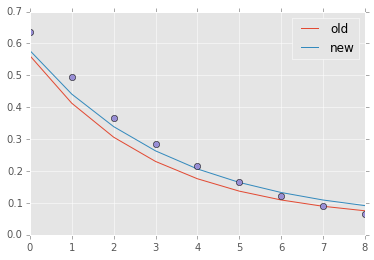

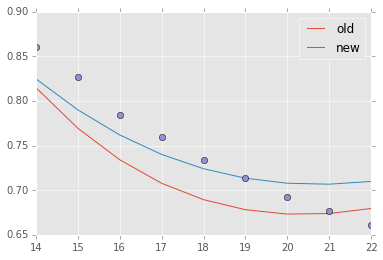

In [265]:
# Redo the regression for S1 and S2 coefficients
from numpy import log
df = load("NACA0021", xfoil=False, csv=True)
df = df[df.alpha_rad > alpha1]
df = df[df.alpha_deg < 25]
alpha = df.alpha_rad
A, B, C, D = 1.0, 0.3, 0.04, 0.66 # Original model
f = pow((sqrt(abs(df.cn)/cn_alpha/abs(df.alpha_rad))*2.0 - 1.0), 2)
f[f > 1] = 1
x = alpha1 - alpha
y = (f - C)/(D)
b = np.sum(x*y*log(y))/sum(x*x*y)
s2b = 1/b
f_high = 0.04 + 0.66*np.exp((alpha1 - df.alpha_rad)/s2)
f_high_b = 0.04 + 0.66*np.exp((alpha1 - df.alpha_rad)/s2b)
cn_high = cn_alpha*df.alpha_rad*((1 + np.sqrt(f_high))/2)**2
cn_high_b = cn_alpha*df.alpha_rad*((1 + np.sqrt(f_high_b))/2)**2
print(s2, s2b)
plt.plot(f_high, label="old")
plt.plot(f_high_b, label="new")
plt.plot(f, "o")
plt.legend()

plt.figure()
plt.plot(df.alpha_deg, cn_high, label="old")
plt.plot(df.alpha_deg, cn_high_b, label="new")
plt.plot(df.alpha_deg, df.cn, "o")
plt.legend()

plt.show()